Assemble one month (Nov 2015) SSH for DFO

In [88]:
import datetime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os

from salishsea_tools import nc_tools
from salishsea_tools import tidetools
from salishsea_tools import viz_tools

%matplotlib inline

(27, 2)


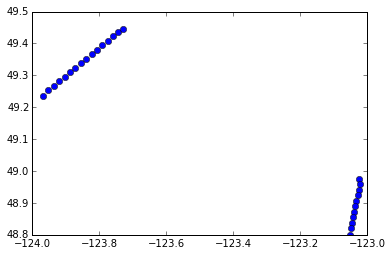

In [21]:
lonslats = np.loadtxt('vh_high_obs_11.dat')
print (lonslats.shape)
fig, ax = plt.subplots(1,1)
ax.plot(lonslats[:,0],lonslats[:,1], 'o')

In [12]:
grid = nc.Dataset('../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bathy = grid.variables['Bathymetry']

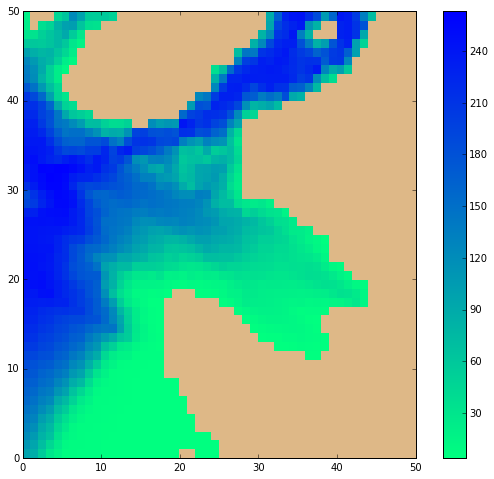

In [13]:
jmin = 300; jmax = 350; imin = 440; imax = 490
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('winter_r')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(bathy[imin:imax,jmin:jmax], cmap=cmap)
fig.colorbar(mesh)

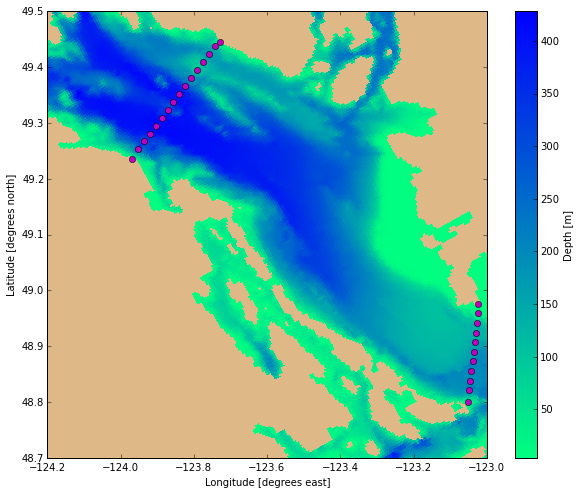

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
aspect = viz_tools.set_aspect(ax, coords='map', lats=lats)
cmap = plt.get_cmap('winter_r')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(lons[:], lats[:], bathy[:], cmap=cmap)
cbar = fig.colorbar(mesh)
plt.axis((-124.2, -123., 48.7, 49.5))

# Add axis labels
ax.set_xlabel('{longitude.long_name} [{longitude.units}]'.format(longitude=lons))
ax.set_ylabel('{latitude.long_name} [{latitude.units}]'.format(latitude=lats))
cbar.set_label('{depth.long_name} [{depth.units}]'.format(depth=bathy))

ax.plot(lonslats[:,0],lonslats[:,1], 'om')

In [73]:
x = np.zeros(lonslats.shape[0])
y = np.zeros_like(x)
for point in range(lonslats.shape[0]):
    y[point], x[point] = tidetools.find_closest_model_point(lons[:], lats[:], 
                                                            lonslats[point,0], lonslats[point,1], bathy[:])

In [74]:
print (x,y)

[ 211.  216.  219.  224.  228.  232.  237.  240.  245.  249.  253.  257.
  261.  265.  270.  272.  316.  316.  313.  310.  307.  304.  302.  299.
  297.  295.  291.] [ 500.  502.  504.  505.  507.  509.  510.  512.  513.  515.  517.  519.
  520.  522.  523.  523.  382.  379.  376.  373.  370.  367.  364.  361.
  358.  354.  351.]


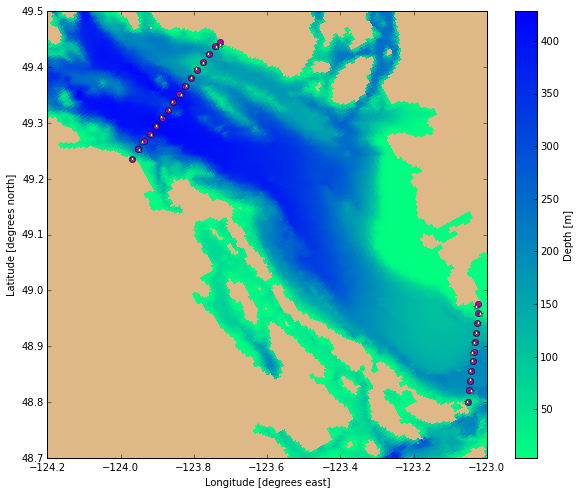

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
aspect = viz_tools.set_aspect(ax, coords='map', lats=lats)
cmap = plt.get_cmap('winter_r')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(lons[:], lats[:], bathy[:], cmap=cmap)
cbar = fig.colorbar(mesh)
plt.axis((-124.2, -123., 48.7, 49.5))

# Add axis labels
ax.set_xlabel('{longitude.long_name} [{longitude.units}]'.format(longitude=lons))
ax.set_ylabel('{latitude.long_name} [{latitude.units}]'.format(latitude=lats))
cbar.set_label('{depth.long_name} [{depth.units}]'.format(depth=bathy))

ax.plot(lonslats[:,0],lonslats[:,1], 'om')
for point in range(lonslats.shape[0]):
    ax.plot(lons[y[point], x[point]], lats[y[point], x[point]], '*w')

In [105]:
npoints = lonslats.shape[0]
lats_out = np.zeros(npoints); lons_out = np.zeros_like(lats_out)
for point in range(npoints):
    lats_out[point] = lats[y[point], x[point]]
    lons_out[point] = lons[y[point], x[point]]
ssh = np.empty((30*24, npoints))

In [51]:
# from analyze.py in nowcast
def get_filenames(t_orig, t_final, period, grid, model_path):
    """Returns a list with the filenames for all files over the
    defined period of time and sorted in chronological order.

    :arg t_orig: The beginning of the date range of interest.
    :type t_orig: datetime object

    :arg t_final: The end of the date range of interest.
    :type t_final: datetime object

    :arg period: Time interval of model results (eg. 1h or 1d).
    :type period: string

    :arg grid: Type of model results (eg. grid_T, grid_U, etc).
    :type grid: string

    :arg model_path: Defines the path used (eg. nowcast)
    :type model_path: string

    :returns: files, a list of filenames
    """

    numdays = (t_final-t_orig).days
    dates = [t_orig + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    dates.sort()

    allfiles = glob.glob(model_path+'*/SalishSea_'+period+'*_'+grid+'.nc')
    sdt = dates[0].strftime('%Y%m%d')
    edt = dates[-1].strftime('%Y%m%d')
    sstr = 'SalishSea_{}_{}_{}_{}.nc'.format(period, sdt, sdt, grid)
    estr = 'SalishSea_{}_{}_{}_{}.nc'.format(period, edt, edt, grid)

    files = []
    for filename in allfiles:
        if os.path.basename(filename) >= sstr:
            if os.path.basename(filename) <= estr:
                files.append(filename)

    files.sort(key=os.path.basename)

    return files

In [114]:
results_home = '/results/SalishSea/nowcast/'
start = datetime.datetime(2015,11,1)
end = datetime.datetime(2015,11,30)
files = get_filenames(start,end,'1h','grid_T',results_home)

In [115]:
for nf, f in enumerate(files):
    grid = nc.Dataset(f)
    sossheig = grid.variables['sossheig'][:]
    for point in range(npoints):
        ssh[0+nf*24:24+nf*24, point] = sossheig[0:24, y[point], x[point]]

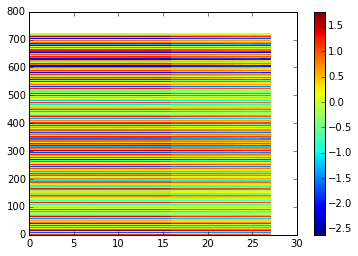

In [116]:
plt.pcolormesh(ssh)
plt.colorbar()

In [124]:
ssh_file = nc.Dataset('SalishSea_ssh_for_DFO.nc', 'w', zlib=True)
nc_tools.init_dataset_attrs(
        ssh_file,
        title='SSH Nov 2015, two lines across SoG',
        notebook_name='SSHforDFO',
        nc_filepath= 'MEOPAR/results/ssh/SalishSea_ssh_for_DFO.nc',
        comment='Hourly SSH for two lines: Lantzville to Sechelt and Saturna to Point Roberts')

ssh_file.createDimension('point', npoints)
ssh_file.createDimension('time_counter', None)

time_counter = ssh_file.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'Seconds since beginning of month'
time_counter.longname = 'time axis'
time_counter.axis = 'T'

# nav_lat and nav_lon
nav_lat = ssh_file.createVariable('nav_lat','float32',('point'),zlib=True)
nav_lon = ssh_file.createVariable('nav_lon','float32',('point'),zlib=True)

# sossheig
ssh_out = ssh_file.createVariable('sossheig', 'float32', 
                               ('time_counter','point'), zlib=True)
ssh_out.units = 'm'
ssh_out.long_name = 'Sea Surface Height'  
ssh_out.coordinates = 'time_counter, point'
ssh_out.grid = 'SalishSea'

for nt in range(24*30):
    time_counter[nt] = 3600*nt
nav_lat[:] = lats_out[:]
nav_lon[:] = lons_out[:]
ssh_out[:] = ssh[:] 
ssh_file.close()

file format: NETCDF4
Conventions: CF-1.6
title: SSH Nov 2015, two lines across SoG
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/analysis/src/tip/Susan/SSHforDFO.ipynb
references: REQUIRED
history: [2016-01-19 12:24:30] Created netCDF4 zlib=True dataset.
comment: Hourly SSH for two lines: Lantzville to Sechelt and Saturna to Point Roberts


In [123]:
ssh_file.close()
ssh_lookat.close()

RuntimeError: NetCDF: Not a valid ID

(720, 27) (720, 27)


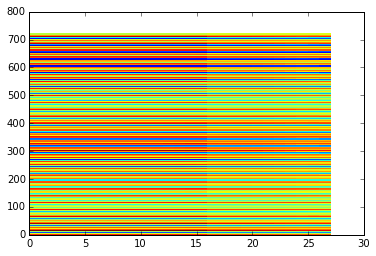

In [125]:
ssh_lookat = nc.Dataset('SalishSea_ssh_for_DFO.nc', 'r')
ss = ssh_lookat.variables['sossheig'][:]
print (ss.shape, ssh.shape)
plt.pcolormesh(ssh)